In [1]:
!pip install transformers
!pip install sentencepiece
!pip install tensorflow
!pip install stanza
!pip install transformers
!pip install tensorflow-addons
!pip install nltk
!pip install textacy
!pip install tqdm

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
from textacy.datasets.supreme_court import SupremeCourt
import numpy as np
import re
import unicodedata
import statistics
import nltk
#from transformers import pipeline
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input, BatchNormalization, Concatenate, Flatten
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
#from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import pandas as pd
from transformers import AutoTokenizer, TFAutoModel
import numpy as np
import gc
import math
import json
import stanza
from tensorflow.keras import *
import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from transformers import TFRobertaModel,RobertaTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import RandomUniform

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset

from numpy.random import seed
import random as python_random
import os
import re
import sys

np.random.seed(1)
python_random.seed(1)
tf.random.set_seed(1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
ydata-profiling 4.12.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.4 MB/s eta 0:00:00


In [2]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    # Rejoin words
    text = " ".join(words)
    return text

In [3]:
# Load SupremeCourt dataset
sc = SupremeCourt()
sc.download()

# Load labels from labels_sc.txt
with open("/kaggle/input/labels-web-of-law/labels_sc.txt", "r") as temp_file:
    labels_sc = temp_file.read().strip().split("\n")  # One label per line

# Ensure the total number of labels matches the records in the dataset
print(f"Total labels in labels_sc.txt: {len(labels_sc)}")

# Initialize lists for texts and labels
texts = []
labels = []

# Iterate over records and use labels from labels_sc.txt
for idx, record in enumerate(sc.records()):
    opinion_text = record.text  # Access the opinion text

    # Include records with valid text and corresponding label from labels_sc
    if opinion_text and idx < len(labels_sc):
        cleaned_text = preprocess_text(opinion_text)
        texts.append(cleaned_text)
        labels.append(int(labels_sc[idx]))  # Use the label directly from labels_sc.txt

# Validate that all labels are within the valid range
num_labels = len(set(labels_sc))  # Total unique labels from labels_sc.txt
assert all(0 <= label < num_labels for label in labels), "Labels are out of range!"

# Convert lists into a DataFrame for further processing
data = pd.DataFrame({"text": texts, "label": labels})
print(f"Total valid records: {len(data)}")
print(data.head())


# Define the LegalTextDataset class
class LegalTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        # Handle missing texts
        self.texts = [text if text else "" for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize the text
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Debugging: Print label distribution
from collections import Counter
label_counts = Counter(labels)
print("Label Distribution:", label_counts)

# Verify the number of unique labels matches the classification task
assert len(label_counts) == num_labels, "Mismatch in the number of unique labels!"




100%|██████████| 111M/111M [00:01<00:00, 85.2MB/s]


Total labels in labels_sc.txt: 8419
Total valid records: 8417
                                                text  label
0  halliburton oil cementing v walker mrearl babc...      8
1  rehearing denied dec mrclaude t barnes salt la...      1
2  rehearing denied dec appeal district court uni...      8
3  mr walter j cummings jr washington dc petition...      2
4  mra devitt vaneck washington dc petitioner mr ...      8
Label Distribution: Counter({1: 1924, 8: 1667, 2: 1359, 9: 1148, 3: 658, 10: 367, 7: 346, 4: 335, 12: 304, 5: 110, 6: 98, 11: 58, 0: 23, 13: 19, 14: 1})


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Padding token is missing. Adding a new padding token...
Padding token: [PAD]
Padding token ID: 50257
env: CUDA_LAUNCH_BLOCKING=1
Epoch 1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Loss: 1.5923
  Accuracy: 0.5061, Precision: 0.4934, Recall: 0.5061, F1-score: 0.4733
Epoch 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Loss: 0.9414
  Accuracy: 0.6958, Precision: 0.6744, Recall: 0.6958, F1-score: 0.6747
Epoch 3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Loss: 0.7117
  Accuracy: 0.7595, Precision: 0.7507, Recall: 0.7595, F1-score: 0.7520
Epoch 4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Loss: 0.5597
  Accuracy: 0.8136, Precision: 0.8080, Recall: 0.8136, F1-score: 0.8097
Epoch 5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Loss: 0.4378
  Accuracy: 0.8541, Precision: 0.8499, Recall: 0.8541, F1-score: 0.8513
Epoch 6


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Loss: 0.3270
  Accuracy: 0.8874, Precision: 0.8864, Recall: 0.8874, F1-score: 0.8857
Epoch 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Loss: 0.2500
  Accuracy: 0.9167, Precision: 0.9159, Recall: 0.9167, F1-score: 0.9158
Epoch 8


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Loss: 0.1776
  Accuracy: 0.9420, Precision: 0.9416, Recall: 0.9420, F1-score: 0.9416
Epoch 9


  Loss: 0.1298
  Accuracy: 0.9599, Precision: 0.9598, Recall: 0.9599, F1-score: 0.9597
Epoch 10


  Loss: 0.0940
  Accuracy: 0.9716, Precision: 0.9716, Recall: 0.9716, F1-score: 0.9715
Validation


Validation Metrics:
  Accuracy: 0.7720, Precision: 0.7696, Recall: 0.7720, F1-score: 0.7675


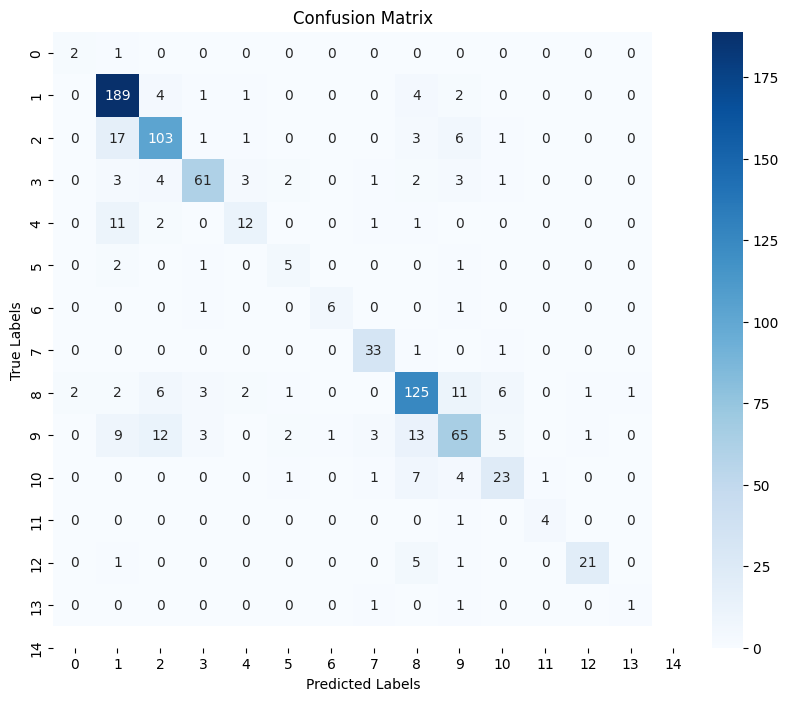

In [4]:
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Initialize tokenizer and model
model_name = "gpt2"  # or any other pre-trained model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Add a padding token to the tokenizer
if tokenizer.pad_token is None:
    print("Padding token is missing. Adding a new padding token...")
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add a padding token
    model.resize_token_embeddings(len(tokenizer))

# Set the padding token ID in the model configuration
model.config.pad_token_id = tokenizer.pad_token_id
print(f"Padding token: {tokenizer.pad_token}")
print(f"Padding token ID: {tokenizer.pad_token_id}")

# Split into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1, random_state=42)

# Create Datasets and DataLoaders
train_dataset = LegalTextDataset(texts=train_texts, labels=train_labels, tokenizer=tokenizer)
val_dataset = LegalTextDataset(texts=val_texts, labels=val_labels, tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# Environment variable for CUDA memory management
%env CUDA_LAUNCH_BLOCKING=1

# Define optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(10):  # Example: 10 epochs
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []

    print(f"Epoch {epoch + 1}")
    for batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(torch.argmax(logits, dim=1).cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average="weighted")
    recall = recall_score(true_labels, predicted_labels, average="weighted")
    f1 = f1_score(true_labels, predicted_labels, average="weighted")

    print(f"  Loss: {total_loss / len(train_loader):.4f}")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Validation Loop
model.eval()
val_true_labels = []
val_predicted_labels = []

print("Validation")
for batch in tqdm(val_loader, desc="Validating", leave=False):
    with torch.no_grad():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        val_true_labels.extend(labels.cpu().numpy())
        val_predicted_labels.extend(torch.argmax(logits, dim=1).cpu().numpy())

# Calculate validation metrics
val_accuracy = accuracy_score(val_true_labels, val_predicted_labels)
val_precision = precision_score(val_true_labels, val_predicted_labels, average="weighted")
val_recall = recall_score(val_true_labels, val_predicted_labels, average="weighted")
val_f1 = f1_score(val_true_labels, val_predicted_labels, average="weighted")

print("Validation Metrics:")
print(f"  Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_predicted_labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_labels), yticklabels=range(num_labels))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [5]:
# Delete all tensors and models
del model
del optimizer
del labels
del texts

# Force garbage collection
import gc
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()


In [6]:
# # Load SupremeCourt dataset
# sc = SupremeCourt()
# sc.download()

# # Load labels from labels_sc.txt
# with open("/kaggle/input/labels-web-of-law/labels_sc_279.txt", "r") as temp_file:
#     labels_sc = temp_file.read().strip().split("\n")  # One label per line

# # Ensure the total number of labels matches the records in the dataset
# print(f"Total labels in labels_sc.txt: {len(labels_sc)}")

# # Initialize lists for texts and labels
# texts = []
# labels = []

# # Iterate over records and use labels from labels_sc.txt
# for idx, record in enumerate(sc.records()):
#     opinion_text = record.text  # Access the opinion text

#     # Include records with valid text and corresponding label from labels_sc
#     if opinion_text and idx < len(labels_sc):
#         cleaned_text = preprocess_text(opinion_text)
#         texts.append(cleaned_text)
#         labels.append(int(labels_sc[idx]))  # Use the label directly from labels_sc.txt

# # Validate that all labels are within the valid range
# num_labels = 279  # Total unique labels from labels_sc.txt
# assert all(0 <= label < num_labels for label in labels), "Labels are out of range!"

# # Convert lists into a DataFrame for further processing
# data = pd.DataFrame({"text": texts, "label": labels})
# print(f"Total valid records: {len(data)}")
# print(data.head())


# # Define the LegalTextDataset class
# class LegalTextDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_len=512):
#         # Handle missing texts
#         self.texts = [text if text else "" for text in texts]
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         # Tokenize the text
#         encoding = self.tokenizer(
#             self.texts[idx],
#             max_length=self.max_len,
#             padding="max_length",
#             truncation=True,
#             return_tensors="pt",
#         )
#         return {
#             "input_ids": encoding["input_ids"].squeeze(0),
#             "attention_mask": encoding["attention_mask"].squeeze(0),
#             "label": torch.tensor(self.labels[idx], dtype=torch.long),
#         }

# # Debugging: Print label distribution
# from collections import Counter
# label_counts = Counter(labels)
# print("Label Distribution:", label_counts)

# # Verify the number of unique labels matches the classification task
# assert len(label_counts) == num_labels, "Mismatch in the number of unique labels!"


# Load SupremeCourt dataset
sc = SupremeCourt()
sc.download()

# Load labels from labels_sc.txt
with open("/kaggle/input/labels-web-of-law/labels_sc_279.txt", "r") as temp_file:
    labels_sc = temp_file.read().strip().split("\n")  # One label per line

# Ensure the total number of labels matches the records in the dataset
print(f"Total labels in labels_sc.txt: {len(labels_sc)}")

# Initialize lists for texts and labels
texts = []
labels = []

# Iterate over records and use labels from labels_sc.txt
for idx, record in enumerate(sc.records()):
    opinion_text = record.text  # Access the opinion text

    # Include records with valid text and corresponding label from labels_sc
    if opinion_text and idx < len(labels_sc):
        cleaned_text = preprocess_text(opinion_text)
        texts.append(cleaned_text)
        labels.append(int(labels_sc[idx]))  # Use the label directly from labels_sc.txt

# Filter out missing labels
present_labels = sorted(set(labels))  # Unique labels in the dataset
label_mapping = {old_label: new_label for new_label, old_label in enumerate(present_labels)}

# Remap labels to contiguous range and filter dataset
filtered_texts = []
filtered_labels = []

for text, label in zip(texts, labels):
    if label in label_mapping:  # Include only valid labels
        filtered_texts.append(text)
        filtered_labels.append(label_mapping[label])

# Update labels and num_labels
texts = filtered_texts
labels = filtered_labels
num_labels = len(present_labels)  # Dynamically update to the number of unique valid labels

# Print updated information
print(f"Number of unique labels after filtering: {num_labels}")
print(f"Filtered dataset: {len(texts)} examples")

# Convert lists into a DataFrame for further processing
data = pd.DataFrame({"text": texts, "label": labels})
print(f"Total valid records: {len(data)}")
print(data.head())


# Define the LegalTextDataset class
class LegalTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        # Handle missing texts
        self.texts = [text if text else "" for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize the text
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Debugging: Print label distribution
from collections import Counter
label_counts = Counter(labels)
print("Label Distribution:", label_counts)

# Verify the number of unique labels matches the classification task
assert len(label_counts) == num_labels, "Mismatch in the number of unique labels!"


Total labels in labels_sc.txt: 8419
Number of unique labels after filtering: 264
Filtered dataset: 8417 examples
Total valid records: 8417
                                                text  label
0  halliburton oil cementing v walker mrearl babc...    197
1  rehearing denied dec mrclaude t barnes salt la...     63
2  rehearing denied dec appeal district court uni...    204
3  mr walter j cummings jr washington dc petition...     99
4  mra devitt vaneck washington dc petitioner mr ...    185
Label Distribution: Counter({18: 238, 180: 216, 77: 204, 15: 200, 225: 181, 125: 181, 189: 161, 185: 142, 3: 134, 123: 117, 30: 115, 186: 114, 192: 112, 26: 107, 184: 106, 25: 103, 151: 100, 228: 100, 90: 99, 182: 90, 245: 87, 22: 86, 183: 84, 95: 83, 93: 83, 224: 80, 88: 80, 191: 79, 2: 79, 145: 78, 156: 78, 19: 76, 226: 75, 143: 75, 100: 69, 190: 68, 10: 63, 89: 63, 50: 61, 40: 61, 146: 59, 197: 55, 163: 53, 181: 53, 222: 53, 17: 51, 79: 50, 227: 50, 139: 50, 103: 49, 155: 48, 23: 48, 201: 47, 

In [7]:
print(f"Number of texts: {len(texts)}")
print(f"Number of labels: {len(labels)}")
print(f"num_labels: {num_labels}, unique labels: {len(set(labels))}")
assert num_labels == len(set(labels)), "Mismatch between num_labels and the actual number of unique labels!"


Number of texts: 8417
Number of labels: 8417
num_labels: 264, unique labels: 264


In [8]:
!export CUDA_LAUNCH_BLOCKING=1

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Padding token is missing. Adding a new padding token...
Padding token: [PAD]
Padding token ID: 50257


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 - Loss: 5.146176117400559
Accuracy: 0.0565, Precision: 0.0208, Recall: 0.0565, F1-score: 0.0239


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2 - Loss: 3.7083527764272035
Accuracy: 0.2704, Precision: 0.2155, Recall: 0.2704, F1-score: 0.2046


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3 - Loss: 2.67537147329123
Accuracy: 0.4358, Precision: 0.3604, Recall: 0.4358, F1-score: 0.3720


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4 - Loss: 2.1713353419536774
Accuracy: 0.5323, Precision: 0.4668, Recall: 0.5323, F1-score: 0.4787


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5 - Loss: 1.771316889215186
Accuracy: 0.6058, Precision: 0.5490, Recall: 0.6058, F1-score: 0.5611


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6 - Loss: 1.4850513157124976
Accuracy: 0.6634, Precision: 0.6294, Recall: 0.6634, F1-score: 0.6279


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7 - Loss: 1.2324334288265757
Accuracy: 0.7183, Precision: 0.6941, Recall: 0.7183, F1-score: 0.6884


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8 - Loss: 1.0179435940894053
Accuracy: 0.7629, Precision: 0.7459, Recall: 0.7629, F1-score: 0.7407


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9 - Loss: 0.8301756931508182
Accuracy: 0.8102, Precision: 0.8006, Recall: 0.8102, F1-score: 0.7930


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10 - Loss: 0.6643695056604648
Accuracy: 0.8498, Precision: 0.8442, Recall: 0.8498, F1-score: 0.8385


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Metrics:
Accuracy: 0.5582, Precision: 0.5532, Recall: 0.5582, F1-score: 0.5347


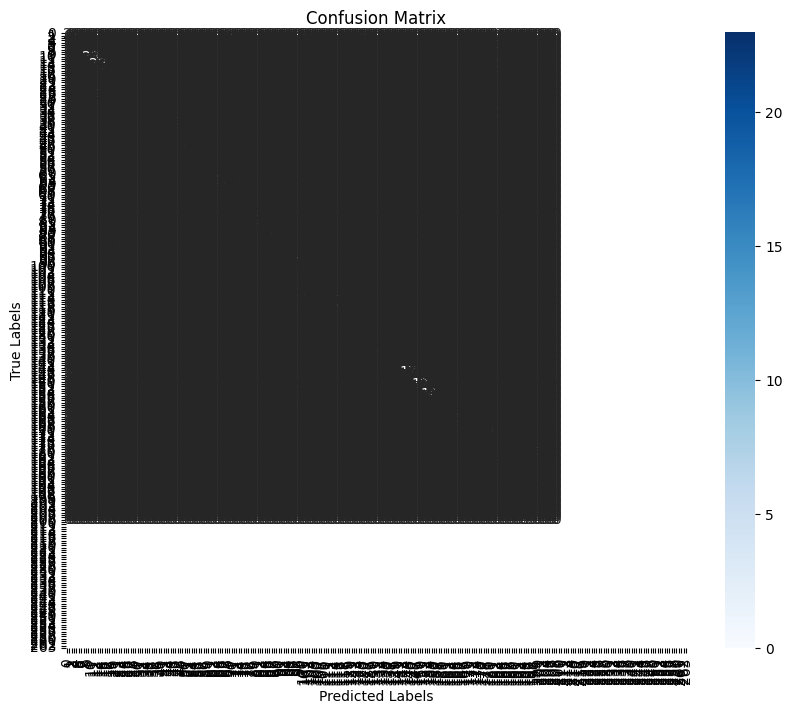

In [9]:
# Initialize tokenizer and model
model_name = "gpt2"  # or any other pre-trained model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Add a padding token to the tokenizer
if tokenizer.pad_token is None:
    print("Padding token is missing. Adding a new padding token...")
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add a padding token

    # Ensure the model's embedding layer matches the updated tokenizer
    model.resize_token_embeddings(len(tokenizer))

# Set the padding token ID in the model configuration
model.config.pad_token_id = tokenizer.pad_token_id

# Print padding token and ID to confirm
print(f"Padding token: {tokenizer.pad_token}")
print(f"Padding token ID: {tokenizer.pad_token_id}")


# Split into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1, random_state=42)

# Create Datasets and DataLoaders
train_dataset = LegalTextDataset(texts = train_texts, labels = train_labels, tokenizer = tokenizer)
val_dataset = LegalTextDataset(texts = val_texts, labels = val_labels, tokenizer = tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop with Metrics
for epoch in range(10):  # Example: 3 epochs
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(torch.argmax(logits, dim=1).cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average="weighted")
    recall = recall_score(true_labels, predicted_labels, average="weighted")
    f1 = f1_score(true_labels, predicted_labels, average="weighted")

    print(f"Epoch {epoch + 1} - Loss: {total_loss / len(train_loader)}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Validation Loop
model.eval()
val_true_labels = []
val_predicted_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Store true and predicted labels
        val_true_labels.extend(labels.cpu().numpy())
        val_predicted_labels.extend(torch.argmax(logits, dim=1).cpu().numpy())

# Calculate validation metrics
val_accuracy = accuracy_score(val_true_labels, val_predicted_labels)
val_precision = precision_score(val_true_labels, val_predicted_labels, average="weighted")
val_recall = recall_score(val_true_labels, val_predicted_labels, average="weighted")
val_f1 = f1_score(val_true_labels, val_predicted_labels, average="weighted")

print("Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_predicted_labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_labels), yticklabels=range(num_labels))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

